<a href="https://colab.research.google.com/github/alyahoang99/Experimentationlog/blob/main/Londontempredictwithwbipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting London Temperature with WB library

https://www.datacamp.com/tutorial/machine-learning-experimentation-an-introduction-to-weights-and-biases

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Import required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Initialize a run
run = wandb.init(project="predicting_london_temperature",
                 job_type="Baseline modeling",
                 save_code=True)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Logging an artifact
We can log any important information, such as dataset, variables, or files as an Artifact. To do this, first create a variable by calling wandb.Artifact(), providing the name and type. Then log this using the wandb.log_artifact() function.

In [ ]:
original_data = '/content/drive/MyDrive/Colab Notebooks/dataset/london_weather.csv'
# create an artifact
data_artifact = wandb.Artifact(name='original_dataset',
                               type='data',
                               description = 'London weather dataset')
# add the file to the artifact
data_artifact.add_file(original_data)
# log the artifact as part of the run
run.log_artifact(data_artifact)

<Artifact original_dataset>

In [ ]:
london = pd.read_csv(original_data)
london.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


<Figure size 2500x1000 with 0 Axes>

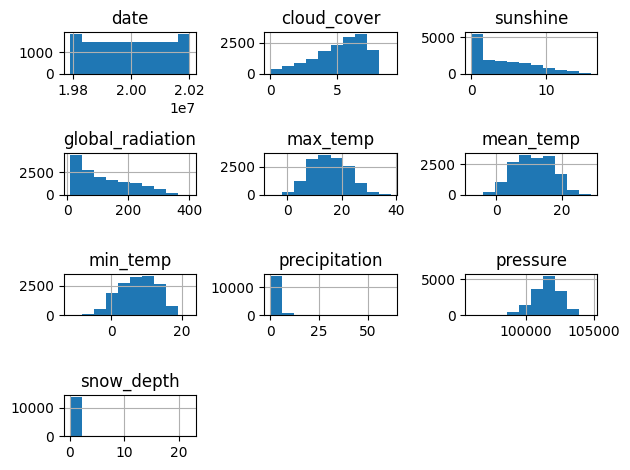

In [ ]:
# visualize distributions
plt.figure(figsize=(25,10))
london.hist()
plt.tight_layout()
plt.show()

In [ ]:
# view data and notnull counts
london.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13843 entries, 0 to 14974
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              13843 non-null  datetime64[ns]
 1   cloud_cover       13843 non-null  float64       
 2   sunshine          13843 non-null  float64       
 3   global_radiation  13843 non-null  float64       
 4   max_temp          13843 non-null  float64       
 5   mean_temp         13843 non-null  float64       
 6   min_temp          13843 non-null  float64       
 7   precipitation     13843 non-null  float64       
 8   pressure          13843 non-null  float64       
 9   snow_depth        13843 non-null  float64       
 10  month             13843 non-null  int32         
dtypes: datetime64[ns](1), float64(9), int32(1)
memory usage: 1.2 MB


In [ ]:
# convert date to datetime
london['date']=pd.to_datetime(london['date'], format='%Y%m%d')
# add a month column
london['month']= london['date'].dt.month
# drop missing values
london.dropna(inplace=True)

In [ ]:
# save and log the new version of the data
london.to_csv("london_weather_preprocessed.csv", index=False)
preprocessed_data = 'london_weather_preprocessed.csv'
# create an artifact
preprocessed_data_artifact = wandb.Artifact(name='london_weather_preprocessed',
                                            type='data',
                                            description='London weather dataset - preprocessed')
# add the file the artifact
preprocessed_data_artifact.add_file(preprocessed_data)
# log the artifact as part of the run
run.log_artifact(preprocessed_data_artifact)

<Artifact london_weather_preprocessed>

## Feature Selection

The next step in the workflow is to identify potential features for modeling while avoiding multicollinearity. To do this, produce a correlation heatmap, then use Ridge Regression to quantify feature importance in predicting "mean_temperature"

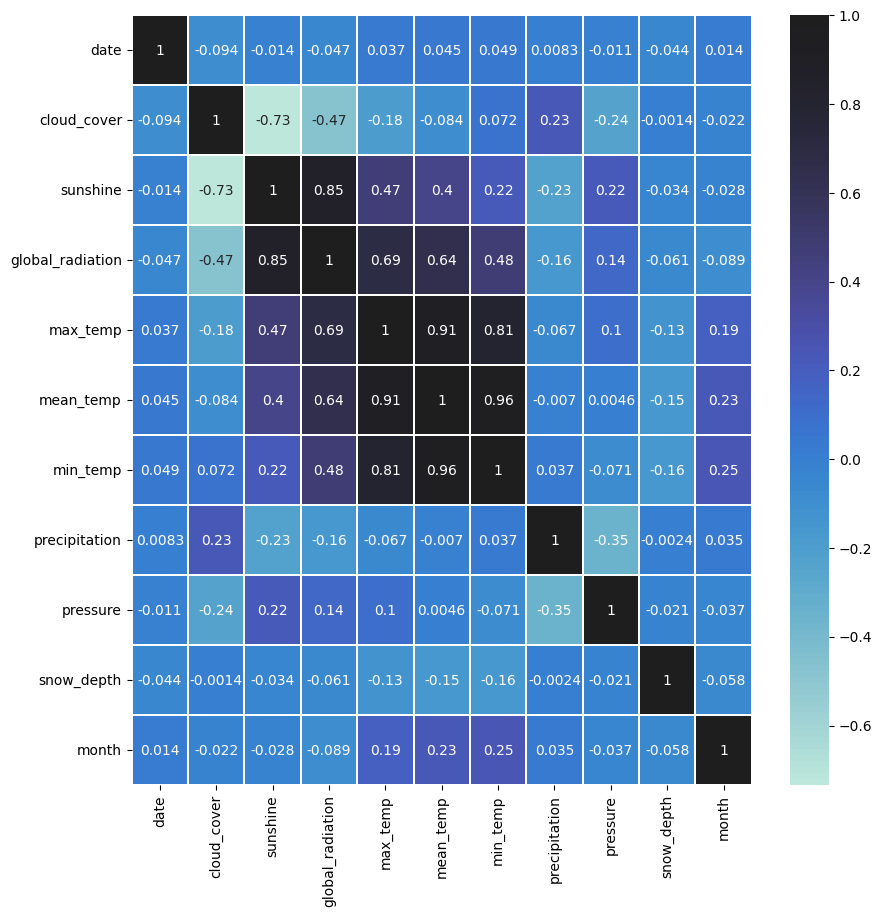

In [ ]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(london.corr(), annot=True, center=True, linewidth=0.3)
plt.show()

In [ ]:
# log the heatmap
wandb.log({'correlation_heatmap': wandb.Image(plt)})

# split the data
X = london.drop(columns=['mean_temp', 'min_temp', 'max_temp', 'date'])
y = london['mean_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

<Figure size 640x480 with 0 Axes>

In [ ]:
# build a ridge regression model
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

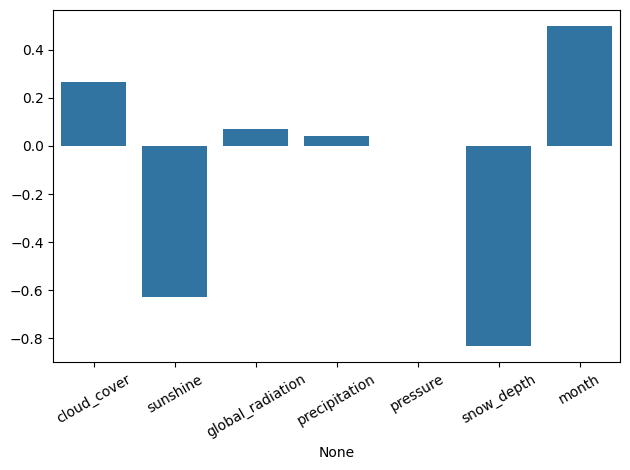

In [ ]:
# visualize feature importance using the coefficients
fig = plt.figure()
sns.barplot(x=X_train.columns, y=ridge.coef_)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('feature_selection.png')
plt.show()

save the model and feature importance plot using pickle.dump() and wandb.log()

In [ ]:
import pickle
pickle.dump(ridge, open('feature_selection_model.pkl', 'wb'))
feature_selection_model = wandb.Artifact('feature_selection_model', type='model')
feature_selection_model.add_file('feature_selection_model.pkl')
run.log_artifact(feature_selection_model)
wandb.log({'feature_selection_plot': wandb.Image(fig)})

## Training and Logging
train baseline model using the identified important features, which are any with a Ridge model coefficient of more than zero. Also log the new training and test data

In [ ]:
X = london[['cloud_cover', 'global_radiation', 'precipitation', 'month']]
y = london['mean_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [ ]:
# create function to log new training and testing data
def log_data(X_train, X_test, y_train, y_test):
  # log the training and test data
  training_features = wandb.Artifact(name='X_train',
                                     type='data',
                                     description='training features')
  X_train.to_csv('X_train.csv', index=False)
  training_features.add_file('X_train.csv')
  run.log_artifact(training_features)

  training_labels = wandb.Artifact(name='y_train',
                                   type='data',
                                   description='Training labels')
  y_train.to_csv('y_train.csv', index=False)

  training_labels.add_file('y_train.csv')
  run.log_artifact(training_labels)

  test_features = wandb.Artifact(name='X_test',
                                 type='data',
                                 description='Test features')
  X_test.to_csv('X_test.csv', index=False)
  test_features.add_file('X_test.csv')
  run.log_artifact(test_features)

  test_labels = wandb.Artifact(name='y_test',
                               type='data',
                               description='Test labels')
  y_test.to_csv('y_test.csv', index=False)
  test_labels.add_file('y_test.csv')
  run.log_artifact(test_labels)

Code explanation
- the code above is a function called 'log_data' that logs the training and test data using the wandb library
- the function takes 4 arguments: X_train, X_test, y_train, y_test
- it create a wandb.Artifact object called 'training_features' to store the training features data
- the csv file is added to the 'training_features' artifact using the add_file() method
- the 'training_features' artifact is logged using the run.log_artifact() method
- similarly, the function creates artifacts for training labels, test features, and test labels.
- each artifact is saved as a CSV file and added to the respective artifact using add_file()
- finally, all the artifacts are logged using run.log_artifact()
- overall, the code takes the training and test data, saves them as csv files, creates artifacts for each file, and logs them using wandb

In [ ]:
  # create a subset of the training data for visualization
  X_train_chart = X_train[:100]
  y_train_chart = y_train[:100]
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_chart)
  X_test_scaled = scaler.transform(X_test)

## Decision Tree Regression model

In [ ]:
# fit and evaluate the model
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_scaled, y_train_chart)
y_pred = dt_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)
print(rmse, r_squared)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


12.588643296660676 -3.886442206582


- create an instance of the DecisionTreeRegressor class and assigns it to the variable dt_reg
- train the decision tree regressor model using the fit() method with the training data X_train and y_train
- predict the target variable values for the test data X_test using the predict() method and assigns it to y_pred
- calculate the root mean squared error (RMSE) btw the actual target values y_tst and the predicted values y_pred using the mean_squared_error() function with the squared=False argument, and assign it to the variable rmse.
- calculate the coefficient of determinatioon (R-squared) between the actual target values y_test and the predicted values y_pred using the r2_score() function, and assigns it to the variable

In [ ]:
# Save and log the model and metrics
pickle.dump(dt_reg, open("baseline_decision_tree.pkl", "wb"))
baseline_model = wandb.Artifact("baseline_decision_tree", type="model")
baseline_model.add_file("baseline_decision_tree.pkl")
run.log_artifact(baseline_model)
wandb.log({"rmse": rmse, "r_squared": r_squared})

- saves the trained decision tree regressor model as a pickle file named 'baseline_decision_tree.pkl'
- createa a wandb.Artifact object named 'baseline_decision_tree' of type 'model'
- add the pickle file 'baseline_decision_tree.pkl' to the baseline_model artifact using the add_file() method
- log the baseline_model artifact using the run.log_artifact() method
- log the values of rmse and r_squared using the wandb.log() function

In [ ]:
# plot training residuals
wandb.log({'baseline_residuals_plot': wandb.sklearn.plot_residuals(dt_reg, X_train_chart, y_train_chart)})

In [ ]:
wandb.finish()

r_squared,▁
rmse,▁
r_squared,-3.88644
rmse,12.58864


## Hyperparameter Tuning
Use GridSearchCV to search for the best performing model across a hyperparameter space, based on RMSE

In [ ]:
# initialize a new run
run_v2 = wandb.init(project='predicting_london_temperature',
                    job_type='hyperparameter tuning',
                    save_code=True)
# split the data and create a KFold object
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

# create the hyperparameter space
params = { "max_depth":[2, 5, 8, 12, 20],
          "min_samples_split": [2, 5, 8, 12, 20],
          "max_features": [1, 2, 3, 4],
          "random_state": [42]
}

# create a GridSearchCV object
dt_reg = DecisionTreeRegressor()
dt_reg_cv = GridSearchCV(dt_reg,
                         params,
                         cv=kf,
                         scoring='neg_root_mean_squared_error')

# fit the data
dt_reg_cv.fit(X_train, y_train)

# evaluate and log performance
print(f"Best RMSE: {-1 * dt_reg_cv.best_score_})")
print(f"Best model: {dt_reg_cv.best_estimator_})")

wandb: Currently logged in as: hoangminhphuong99 (alyahoang99). Use `wandb login --relogin` to force relogin


Best RMSE: 2.932135504679972)
Best model: DecisionTreeRegressor(max_depth=8, max_features=4, min_samples_split=20,
                      random_state=42))


In [ ]:
# Save and log the model, metrics and parameters
pickle.dump(dt_reg_cv, open('tuned_decision_tree.pkl', 'wb'))
tuned_decision_tree = wandb.Artifact('tuned_decision_tree', type='model')
tuned_decision_tree.add_file('tuned_decision_tree.pkl')
run_v2.log_artifact(tuned_decision_tree)
wandb.log({'rmse': -1 * dt_reg_cv.best_score_})
wandb.finish()

rmse,▁
rmse,2.93214


In [35]:
!git clone https://github.com/alyahoang99/Experimentationlog.git

fatal: destination path 'Experimentationlog' already exists and is not an empty directory.


In [36]:
!git init


Reinitialized existing Git repository in /content/.git/


In [34]:
!git remote add notebook  https://github.com/alyahoang99/Experimentationlog.git